# Train model

This notebook is to train the model.
1. First, some feature engineering is conducted to prepare the dataset and add the more details possible.
2. Then, a first model is trained using cross validation and expanding window validation to validate the model. The model and info are loaded to MLflow to store the different models and track the performances.
3. Finally, the best model is run on the entire train set.

# 1. Imports

## 1.1 Packages

In [7]:
import os
import pandas as pd
import sys

In [8]:
# Load custom functions
sys.path.append("../src/")
from feature_engineering import extract_date_features, add_lockdown_periods, add_holidays_period, get_split_cv_by_week
from train_model import train_model_cv_mlflow, train_model, create_pool, save_model

## 1.2 Options

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Define some parameters

path_data = "../data/processed"

feat_date = "Date"

## 1.3 Datasets

In [11]:
# Load the train set and its target

df_train = pd.read_pickle(os.path.join(path_data, "train.pkl"))
y_train = pd.read_csv(os.path.join(path_data, "target_train.csv"), index_col=0)

# 2. Prepare data

## 2.1 Feature engineering

To prepare data, the following feature engineering is done:
1. Extract info from date: year, month, day, day of the week and if its weekend or not
2. Add an indicator of the lockdown period: if there was a lockdown, and which one (first, second or thrid one)
3. Add holidays period for Zone A in France
4. Add holidays period for Zone B in France
5. Add holidays period for Zone C in France

(Having some geographical information could let us add just the right holidays period depending on the zone)

6. Drop columns Date and Fourni which will not be used in the model

In [12]:
df_date_train = df_train[feat_date]

df_train = df_train.pipe(extract_date_features, feat_date=feat_date)\
    .pipe(add_lockdown_periods, feat_date=feat_date)\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone A")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone B")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone C")\
    .drop(columns=[feat_date, "Fourni"])

In [13]:
df_train

,id,sma_1_ventes_lag14,sma_2_ventes_lag14,sma_3_ventes_lag14,sma_4_ventes_lag14,sma_5_ventes_lag14,sma_6_ventes_lag14,sma_7_ventes_lag14,sma_10_ventes_lag14,sma_13_ventes_lag14,...,sma_34_ventes_lag14,Date_year,Date_month,Date_day,Date_weekday,Date_weekend,lockdown,Description_ZoneA,Description_ZoneB,Description_ZoneC
63,6199345349144345845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
72,-876129535061941331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
1,-8929187383922749181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
24,8464427600310081793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
2,5557283775796994165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82388,-7098573545404969117,18.0,16.0,13.333333,12.25,11.6,11.333333,11.714286,12.2,11.076923,...,11.764706,2023,4,2,6,1,0,None,None,None
82389,2942031581314612067,8.0,6.5,5.666667,4.75,4.6,4.666667,4.571429,4.8,4.615385,...,3.941176,2023,4,2,6,1,0,None,None,None
82365,6421054819254012950,45.0,31.0,26.333333,20.50,19.8,20.166667,21.285714,23.8,21.461538,...,21.941176,2023,4,2,6,1,0,None,None,None
82384,-3559041973219712811,3.0,2.5,1.666667,1.25,1.0,0.833333,0.714286,2.5,2.153846,...,1.235294,2023,4,2,6,1,0,None,None,None


In [14]:
# Define the categorical columns for the model
feat_cat = ["id", "Date_weekend", "lockdown", "Description_ZoneA", "Description_ZoneB", "Description_ZoneC"]

## 2.2 Split into folds

The train set is split into folds using expanding window validation. It means, we select one portion of the set as the train set, and the portion after as the validation. Then the validation set is added to the train set and a period after is the new validation set, and so on.

We consider that we need to predict the number of sales two weeks before in order to prepare everything (printing, delivery, etc.). Therefore, each window represents one week.

In [15]:
# Split the train set into different folds
list_train_valid = get_split_cv_by_week(df_train.copy(), df_date_train, feat_date=feat_date, target=y_train, n_splits=5)

Dates for the split: DatetimeIndex(['2023-01-22', '2023-02-05', '2023-02-19', '2023-03-05',
               '2023-03-19', '2023-04-02'],
              dtype='datetime64[ns]', freq='2W-SUN')


# 3. Train model

## 3.1 Cross validation and hyperparameters search

Cross validation is used to train a model and analyze the performance on different windows.

For the hyperparameters search, MLflow is used to track the different tests and save models. We log the hyperparameters, the metrics, and SHAP values to MLflow to save between the different runs.

Bayesian optimisation could help find the best hyperparameters for the model with an optimized method to look in the right space for the hyper parameters search. However, it is very long and computation cost method so we stick with this simple search method. Plus, the default parameters of Catboost are good enough. 



__Run info__:

The first metric used was RMSE. However, we consider that the goal is to limit the number of sold outs, a quantile metric has better performance.

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


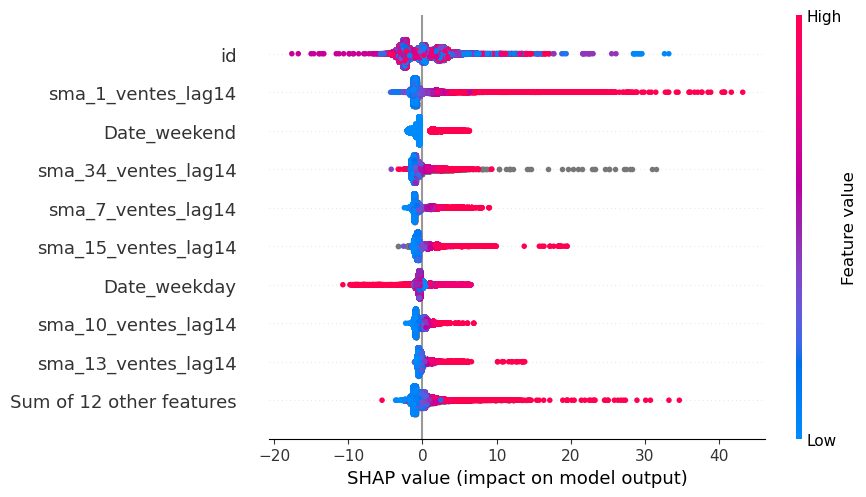

In [26]:
params = {
    "iterations": 1000,
    "depth": 5,
    # "loss_function": "RMSE",
    "loss_function": "Quantile:alpha=0.75",
    # "learning_rate": 0.07,
    "early_stopping_rounds": 100,
}

model, pred_train, pred_valid = train_model_cv_mlflow(
    list_train_valid=list_train_valid,
    feat_cat=feat_cat, plot_training=False, verbose=0,
    **params
)

## 3.2 Final model

Train a final model on the entire train set using the hyperparameters selected by the previous runs

In [27]:
params_final = params
params_final["learning_rate"] = model.get_all_params()["learning_rate"]
params_final["iterations"] = model.get_best_iteration()
print(params_final)

pool_train = create_pool(df_train, y_train, feat_cat=feat_cat)
model_final = train_model(pool_train=pool_train, pool_eval=None, plot_training=True, verbose=100, **params_final)
save_model(model_final, features=df_train.columns.tolist(), feat_cat=feat_cat, path="../models/model_final.json")

{'iterations': 992, 'depth': 5, 'loss_function': 'Quantile:alpha=0.75', 'early_stopping_rounds': 100, 'learning_rate': 0.029999999329447743}


iteritems is deprecated and will be removed in a future version. Use .items instead.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.9872626	total: 68.7ms	remaining: 1m 8s


You should provide test set for use best model. use_best_model parameter has been switched to false value.


100:	learn: 3.8653928	total: 1.88s	remaining: 16.6s
200:	learn: 3.8496112	total: 3.73s	remaining: 14.7s
300:	learn: 3.8419649	total: 5.57s	remaining: 12.8s
400:	learn: 3.8353038	total: 7.39s	remaining: 10.9s
500:	learn: 3.8285145	total: 9.23s	remaining: 9.05s
600:	learn: 3.8225038	total: 11.1s	remaining: 7.24s
700:	learn: 3.8173379	total: 12.8s	remaining: 5.33s
800:	learn: 3.8120979	total: 14.6s	remaining: 3.48s
900:	learn: 3.8084682	total: 16.3s	remaining: 1.65s
991:	learn: 3.8057626	total: 17.8s	remaining: 0us
